In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from datetime import date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearnex import patch_sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

## Traffic data
The traffic data that is imported here is taken from the **TrafficDataCleaning file**, where detailed steps about the cleaning of the dataset have been specified as well as a data dictionary with data requirements. 
### Importing the data

In [3]:
traffic_data = pd.read_csv("datasets/CleanTraffic.csv")
traffic_data.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseCodeDescr,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime
653514,3881935,2023-12-14,2023-12-14,17:29:31,17:42:00,31.168,2497.000,12.483,45.0,43.2,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 12],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-12-14 17:29:31,2023-12-14 17:42:00
1646351,2829613,2021-07-01,2021-07-01,8:00:00,8:29:03,90.250,3106.713,29.050,24.6,28.6,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 29],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2021-07-01 08:00:00,2021-07-01 08:29:03
1520576,2944953,2022-02-25,2022-02-25,15:53:35,15:59:01,16.868,3105.000,5.433,57.2,55.0,...,Spitsfile (geen oorzaak gemeld),[Geen oorzaakcode opgegeven door VWM 5],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-02-25 15:53:35,2022-02-25 15:59:01


In [4]:
traffic_data.shape

(1714882, 28)

### Checking the data types and missing values

In [5]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714882 entries, 0 to 1714881
Data columns (total 28 columns):
 #   Column               Dtype  
---  ------               -----  
 0   TrafficJamNum        int64  
 1   StartDate            object 
 2   EndDate              object 
 3   StartTime            object 
 4   EndTime              object 
 5   Severity             float64
 6   Length               float64
 7   Duration             float64
 8   HectometerStart      float64
 9   HectometerEnd        float64
 10  RoadLetter           object 
 11  RoadNumber           int64  
 12  RoadDescr            object 
 13  HectometerDirection  object 
 14  RoadSectionFrom      object 
 15  RoadSectionTo        object 
 16  MainRoadFrom         object 
 17  MainRoadTo           object 
 18  CauseCodeDescr       object 
 19  CauseClass           object 
 20  CauseCodeClass       object 
 21  CauseCode            object 
 22  Cause_1              object 
 23  Cause_2              object 
 24

In [6]:
traffic_data.isna().sum()

TrafficJamNum          0
StartDate              0
EndDate                0
StartTime              0
EndTime                0
Severity               0
Length                 0
Duration               0
HectometerStart        0
HectometerEnd          0
RoadLetter             0
RoadNumber             0
RoadDescr              0
HectometerDirection    0
RoadSectionFrom        0
RoadSectionTo          0
MainRoadFrom           0
MainRoadTo             0
CauseCodeDescr         0
CauseClass             0
CauseCodeClass         0
CauseCode              0
Cause_1                0
Cause_2                0
Cause_3                0
Cause_4                0
StartDateTime          0
EndDateTime            0
dtype: int64

### Altering data
#### Adding hour

In [7]:
traffic_data['Hour'] = traffic_data['StartTime'].apply(lambda x: x.split(':')[0]).astype(int)
traffic_data.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour
797910,3348341,2023-01-12,2023-01-12,15:37:31,15:39:00,2.967,2000.000,1.483,1.8,3.8,...,[Geen oorzaakcode opgegeven door VWM 1],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-01-12 15:37:31,2023-01-12 15:39:00,15
217698,3853841,2023-11-30,2023-11-30,6:49:25,6:51:00,3.483,2200.000,1.583,21.7,23.9,...,[Geen oorzaakcode opgegeven door VWM 2],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-11-30 06:49:25,2023-11-30 06:51:00,6
1591835,2905087,2021-11-15,2021-11-15,15:33:00,16:04:23,108.195,3447.531,31.383,93.6,91.0,...,"[Geen oorzaakcode opgegeven door VWM 7], [Opru...","[000], [CLE], [ACA]",ACI,Ongeval(len),Ongeval,Ongeval,Ongeval,2021-11-15 15:33:00,2021-11-15 16:04:23,15


#### Keeping only relevant roads

As we want to only have the specific roads that our client can possibly use to reach the offices, we will prepare the data for joining by filtering on the roads A2 and A73.
An important observation is that **A2 leads from Sittard to 's-Hertogenbosch** and vice versa, whereas **A73 leads from Sittard to Boxmeer** and vice versa. Other routes are also possible, but they are significantly slower. Therefore, it is better to focus on those two only for now. Furthermore, they have been suggested by the client as the optimal routes.

In [8]:
filtered_traffic= traffic_data[(traffic_data['RoadDescr'] == 'A73') | (traffic_data['RoadDescr'] == 'A2')]
filtered_traffic.sample(3)

,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseClass,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour
1059462,2623126,2019-09-14,2019-09-14,11:18:00,13:00:17,525.467,5137.364,102.283,165.2,167.2,...,"[Geen oorzaakcode opgegeven door VWM 1], [Onge...","[000], [ACI], [OCL], [ACA]",ACI,Ongeval(len),Ongeval,Ongeval,Ongeval,2019-09-14 11:18:00,2019-09-14 13:00:17,11
33813,4002592,2024-03-25,2024-03-25,17:21:32,17:55:03,62.093,1853.000,33.517,91.9,91.9,...,[Geen oorzaakcode opgegeven door VWM 34],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2024-03-25 17:21:32,2024-03-25 17:55:03,17
424766,3057534,2022-06-02,2022-06-02,17:12:29,17:18:01,6.640,1200.000,5.533,37.0,37.1,...,[Geen oorzaakcode opgegeven door VWM 6],[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2022-06-02 17:12:29,2022-06-02 17:18:01,17


In [9]:
denb=filtered_traffic[(filtered_traffic["MainRoadFrom"] == "'s-Hertogenbosch")&(filtered_traffic["MainRoadTo"] == "Utrecht")]
denb["HectometerDirection"].unique()

array(['aflopend'], dtype=object)

### Making the direction numerical
0 = Morning (Sittard - Den Bosch)

1 = Afternoon (Den Bosch - Sittard)

In [10]:
warnings.filterwarnings('ignore')
filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="oplopend", 'HectometerDirectionNum'] = 1
filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="aflopend", 'HectometerDirectionNum'] = 0

filtered_traffic.sample(3)

C:\Users\zashe\AppData\Local\Temp\ipykernel_19332\1781117567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_traffic.loc[filtered_traffic["HectometerDirection"]=="oplopend", 'HectometerDirectionNum'] = 1


,TrafficJamNum,StartDate,EndDate,StartTime,EndTime,Severity,Length,Duration,HectometerStart,HectometerEnd,...,CauseCodeClass,CauseCode,Cause_1,Cause_2,Cause_3,Cause_4,StartDateTime,EndDateTime,Hour,HectometerDirectionNum
361082,3433087,2023-03-15,2023-03-15,7:25:25,7:27:00,3.483,2200.000,1.583,186.0,188.2,...,[000],001,Spitsfile (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-03-15 07:25:25,2023-03-15 07:27:00,7,0.0
1496368,2278176,2018-01-18,2018-01-18,6:50:00,7:37:53,171.933,3590.672,47.883,187.4,189.4,...,"[000], [ACI], [ACA]",ACI,Ongeval(len),Ongeval,Ongeval,Ongeval,2018-01-18 06:50:00,2018-01-18 07:37:53,6,0.0
631367,3647327,2023-07-14,2023-07-14,11:30:28,11:32:00,3.527,2300.000,1.533,60.2,57.9,...,[000],003,File buiten spits (geen oorzaak gemeld),Geen oorzaak gemeld,Drukte,Hoge intensiteit,2023-07-14 11:30:28,2023-07-14 11:32:00,11,1.0


### Removing useless columns

In [11]:
numerical_columns = filtered_traffic.select_dtypes(include=['int64', 'float64', 'int32'])
desired_columns = ["StartDate", "Duration", "RoadNumber", "Hour", "HectometerDirectionNum"]
selected_columns = filtered_traffic.loc[:, desired_columns]
selected_columns['StartDate'] = pd.to_datetime(selected_columns['StartDate'])
selected_columns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209047 entries, 9 to 1714873
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   StartDate               209047 non-null  datetime64[ns]
 1   Duration                209047 non-null  float64       
 2   RoadNumber              209047 non-null  int64         
 3   Hour                    209047 non-null  int32         
 4   HectometerDirectionNum  209047 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 8.8 MB


It can be concluded that the file got imported correctly and is ready to be used further.
## Calendar

In [12]:
def create_date_table2(start, end):
    date_range = pd.date_range(start=start, end=end, freq='h')
    df = pd.DataFrame({"DateTime": date_range})
    df["StartDate"] = df["DateTime"].dt.date
    df["Hour"] = df["DateTime"].dt.hour
    return df

calendar = create_date_table2(start='2015-01-01', end=selected_columns['StartDate'].max())
calendar = calendar.drop(calendar.columns[0], axis=1)
calendar['StartDate'] = pd.to_datetime(calendar['StartDate'])
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82705 entries, 0 to 82704
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   StartDate  82705 non-null  datetime64[ns]
 1   Hour       82705 non-null  int32         
dtypes: datetime64[ns](1), int32(1)
memory usage: 969.3 KB


### Join road A2 and direction 1

In [13]:
a2d1 = selected_columns[(selected_columns['RoadNumber']==2)&(selected_columns['HectometerDirectionNum']==1)]
a2d1.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
41493,2024-04-08,1.483,2,8,1.0
1110279,2020-01-23,26.217,2,17,1.0


In [14]:
mergedoutera2d1 = pd.merge(calendar, a2d1, how='left', on=['StartDate', 'Hour'])
mergedoutera2d1.isna().sum()

StartDate                     0
Hour                          0
Duration                  68061
RoadNumber                68061
HectometerDirectionNum    68061
dtype: int64

In [15]:
mergedoutera2d1['Duration'] = mergedoutera2d1['Duration'].fillna(0)
mergedoutera2d1['RoadNumber'] = mergedoutera2d1['RoadNumber'].fillna(2)
mergedoutera2d1['HectometerDirectionNum'] = mergedoutera2d1['HectometerDirectionNum'].fillna(1)
mergedoutera2d1.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [16]:
mergedoutera2d1.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
103549,2021-12-14,22,0.00,2.0,1.0
29265,2016-11-15,17,13.65,2.0,1.0


### Join road A2 and direction 0

In [17]:
a2d0 = selected_columns[(selected_columns['RoadNumber']==2)&(selected_columns['HectometerDirectionNum']==0)]
a2d0.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
821324,2019-11-14,15.900,2,17,0.0
126622,2024-06-06,13.533,2,8,0.0


In [18]:
mergedoutera2d0 = pd.merge(calendar, a2d0, how='left', on=['StartDate', 'Hour'])
mergedoutera2d0.isna().sum()

StartDate                     0
Hour                          0
Duration                  67311
RoadNumber                67311
HectometerDirectionNum    67311
dtype: int64

In [19]:
mergedoutera2d0['Duration'] = mergedoutera2d0['Duration'].fillna(0)
mergedoutera2d0['RoadNumber'] = mergedoutera2d0['RoadNumber'].fillna(2)
mergedoutera2d0['HectometerDirectionNum'] = mergedoutera2d0['HectometerDirectionNum'].fillna(0)
mergedoutera2d0.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [20]:
mergedoutera2d0.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
39081,2017-11-06,1,0.00,2.0,0.0
895,2015-01-26,9,5.05,2.0,0.0


### Join A73 and direction 1

In [21]:
a73d1 = selected_columns[(selected_columns['RoadNumber']==73)&(selected_columns['HectometerDirectionNum']==1)]
a73d1.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
631867,2023-07-13,4.517,73,17,1.0
68114,2024-04-22,4.517,73,15,1.0


In [22]:
mergedoutera73d1 = pd.merge(calendar, a73d1, how='left', on=['StartDate', 'Hour'])
mergedoutera73d1.isna().sum()

StartDate                     0
Hour                          0
Duration                  78221
RoadNumber                78221
HectometerDirectionNum    78221
dtype: int64

In [23]:
mergedoutera73d1['Duration'] = mergedoutera73d1['Duration'].fillna(0)
mergedoutera73d1['RoadNumber'] = mergedoutera73d1['RoadNumber'].fillna(73)
mergedoutera73d1['HectometerDirectionNum'] = mergedoutera73d1['HectometerDirectionNum'].fillna(1)
mergedoutera73d1.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [24]:
mergedoutera73d1.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
52294,2020-10-17,8,0.000,73.0,1.0
67959,2022-06-15,17,8.517,73.0,1.0


### Join A73 and direction 0

In [25]:
a73d0 = selected_columns[(selected_columns['RoadNumber']==73)&(selected_columns['HectometerDirectionNum']==0)]
a73d0.sample(2)

,StartDate,Duration,RoadNumber,Hour,HectometerDirectionNum
4558,2024-03-13,1.533,73,16,0.0
524151,2022-05-20,1.550,73,14,0.0


In [26]:
mergedoutera73d0 = pd.merge(calendar, a73d0, how='left', on=['StartDate', 'Hour'])
mergedoutera73d0.isna().sum()

StartDate                     0
Hour                          0
Duration                  79686
RoadNumber                79686
HectometerDirectionNum    79686
dtype: int64

In [27]:
mergedoutera73d0['Duration'] = mergedoutera73d0['Duration'].fillna(0)
mergedoutera73d0['RoadNumber'] = mergedoutera73d0['RoadNumber'].fillna(73)
mergedoutera73d0['HectometerDirectionNum'] = mergedoutera73d0['HectometerDirectionNum'].fillna(0)
mergedoutera73d0.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [28]:
mergedoutera73d0.sample(2)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
73622,2023-02-07,4,0.000,73.0,0.0
81443,2023-09-29,17,2.667,73.0,0.0


### Appending the 4 dataframes

In [29]:
dataframes = [mergedoutera2d0, mergedoutera2d1, mergedoutera73d0, mergedoutera73d1]
appended_frame = pd.concat(dataframes, axis=0)
appended_frame.isna().sum()

StartDate                 0
Hour                      0
Duration                  0
RoadNumber                0
HectometerDirectionNum    0
dtype: int64

In [30]:
appended_frame.shape

(502317, 5)

In [31]:
appended_frame.sample(5)

,StartDate,Hour,Duration,RoadNumber,HectometerDirectionNum
81812,2023-10-11,10,0.000,73.0,0.0
142918,2023-12-08,11,0.000,2.0,0.0
39581,2017-06-29,18,8.850,2.0,1.0
16724,2016-11-19,1,0.000,73.0,1.0
83284,2023-11-23,17,5.467,73.0,0.0


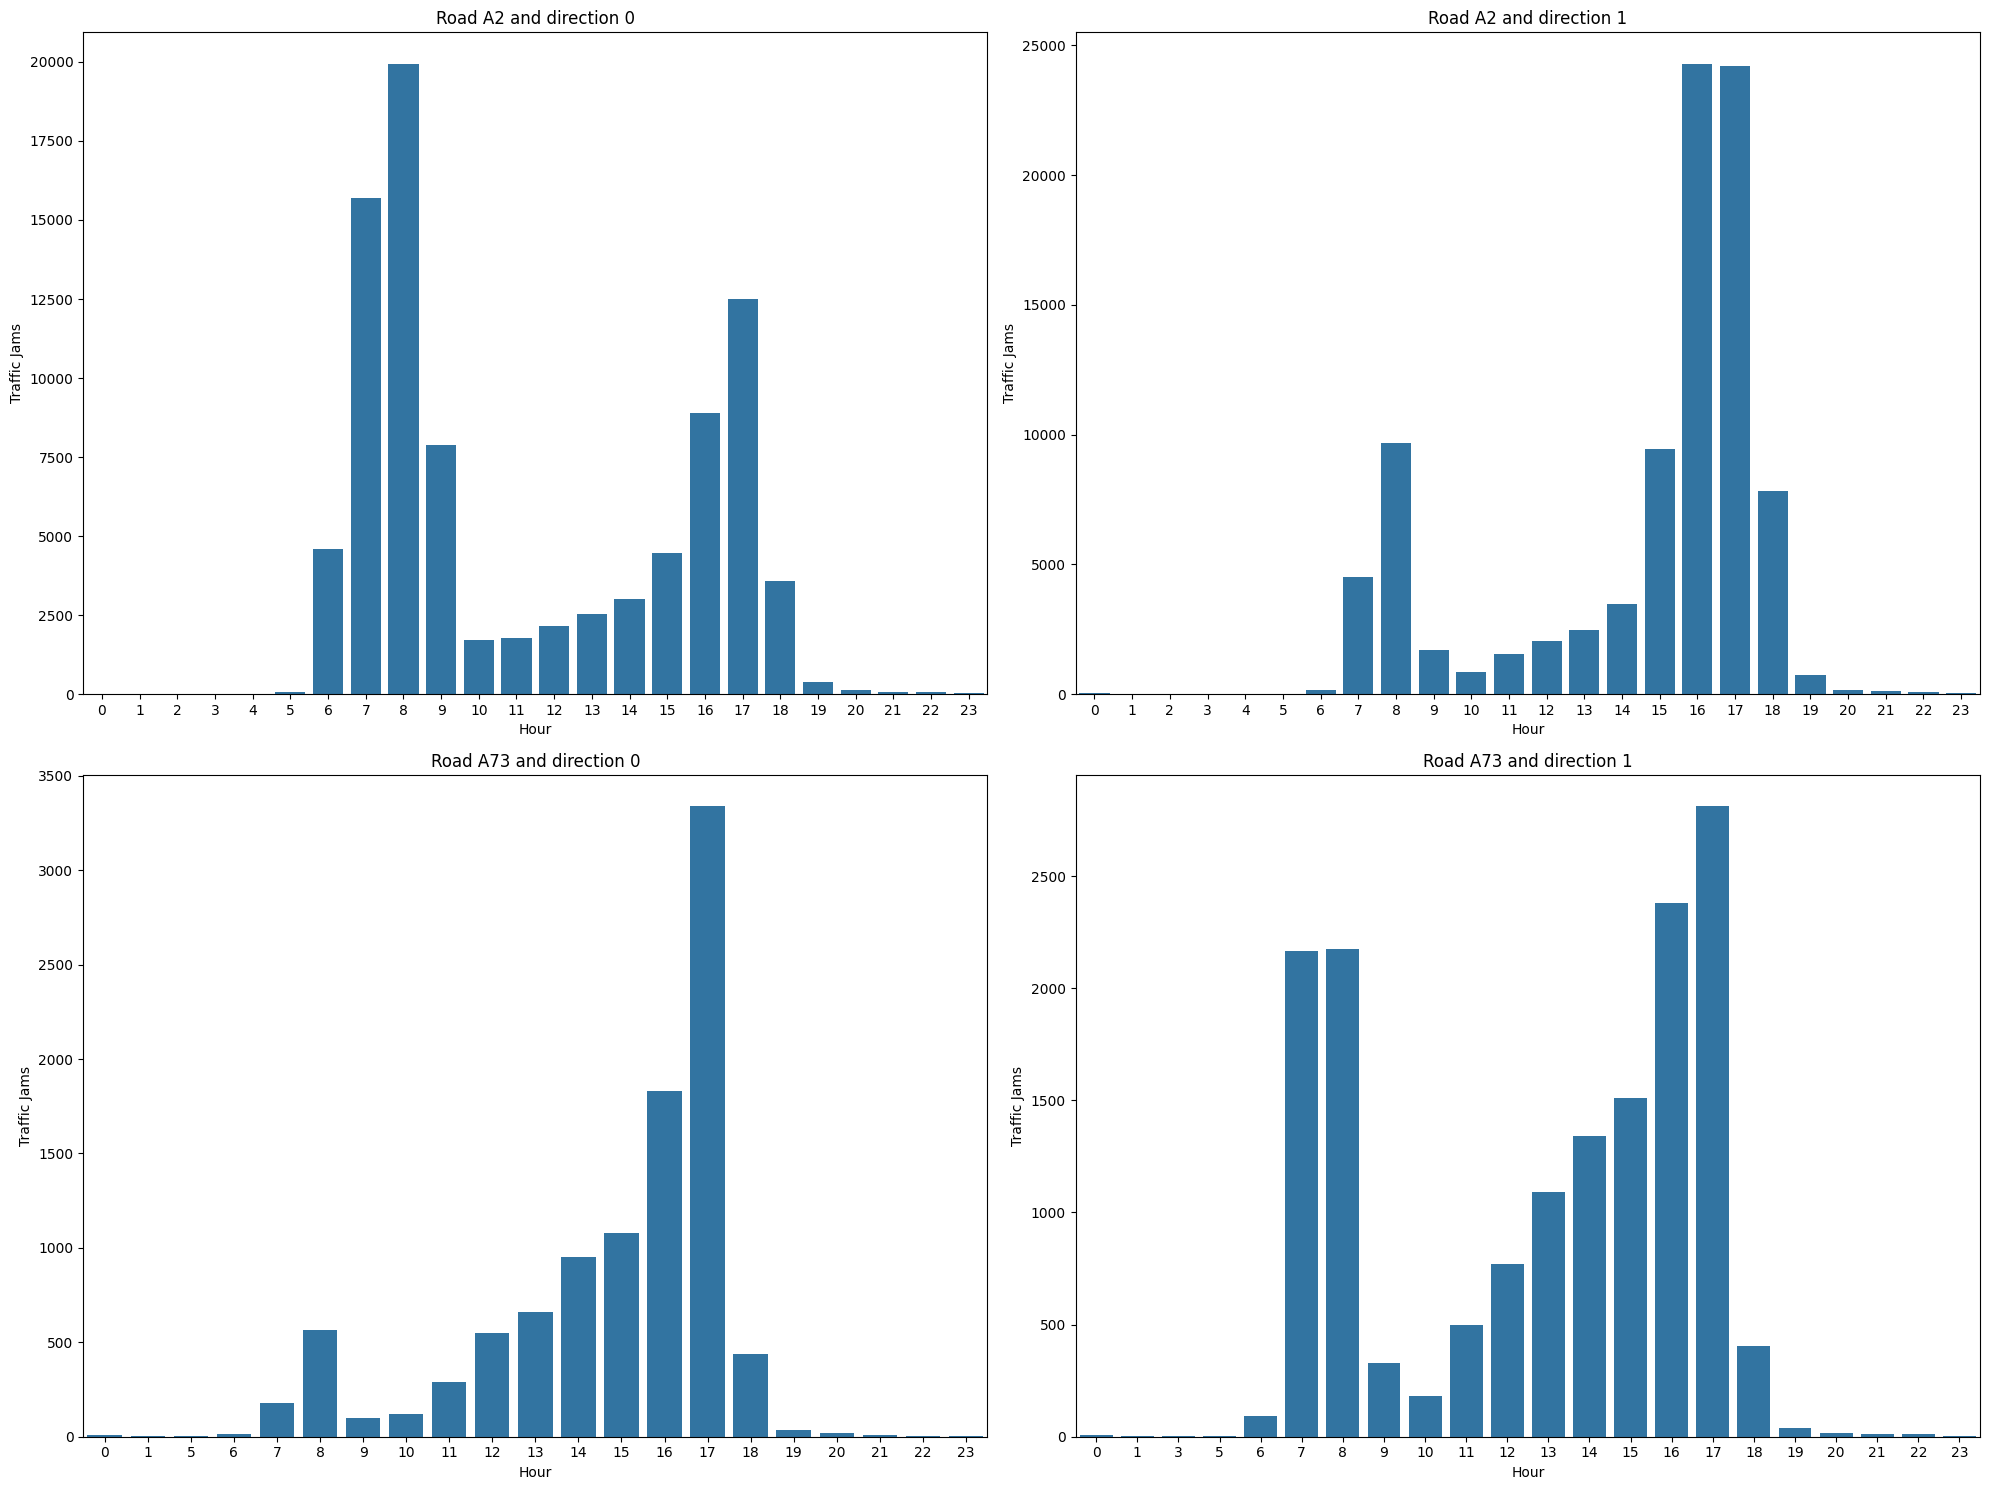

In [32]:
import seaborn as sns

actualtr0 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==0)&(appended_frame['RoadNumber']==2)]
actualtr0 = actualtr0['Hour'].value_counts().sort_index() 

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.barplot(x=actualtr0.index, y=actualtr0.values, ax = axes[0,0])
axes[0, 0].set_title('Road A2 and direction 0')
axes[0, 0].set_xlabel('Hour')
axes[0, 0].set_ylabel('Traffic Jams')


actualtr1 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==1)&(appended_frame['RoadNumber']==2)]
actualtr1 = actualtr1['Hour'].value_counts().sort_index()

sns.barplot(x=actualtr1.index, y=actualtr1.values, ax = axes[0,1])
axes[0, 1].set_title('Road A2 and direction 1')
axes[0, 1].set_xlabel('Hour')
axes[0, 1].set_ylabel('Traffic Jams')

actualtr2 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==0)&(appended_frame['RoadNumber']==73)]
actualtr2 = actualtr2['Hour'].value_counts().sort_index() 


sns.barplot(x=actualtr2.index, y=actualtr2.values, ax = axes[1,0])
axes[1, 0].set_title('Road A73 and direction 0')
axes[1, 0].set_xlabel('Hour')
axes[1, 0].set_ylabel('Traffic Jams')


actualtr3 = appended_frame[(appended_frame['Duration']!=0)&(appended_frame['HectometerDirectionNum']==1)&(appended_frame['RoadNumber']==73)]
actualtr3 = actualtr3['Hour'].value_counts().sort_index()

sns.barplot(x=actualtr3.index, y=actualtr3.values, ax = axes[1,1])
axes[1, 1].set_title('Road A73 and direction 1')
axes[1, 1].set_xlabel('Hour')
axes[1, 1].set_ylabel('Traffic Jams')

plt.tight_layout()
plt.show()

## Creating the category column

In [42]:
bins = [-np.inf, 0, 15, 30, np.inf]
labels = ['none', 'light', 'medium', 'heavy']
category_mapping = {'none': 0, 'light': 1, 'medium': 2, 'heavy': 3}

appended_frame['Duration Category'] = pd.cut(appended_frame['Duration'].fillna(0), bins=bins, labels=labels)
appended_frame['encoded_type'] = appended_frame['Duration Category'].map(category_mapping)
appended_frame['encoded_type'] = appended_frame['encoded_type'].astype(int)

appended_frame["Duration Category"].value_counts()

Duration Category
none      293279
light     151066
heavy      30559
medium     27413
Name: count, dtype: int64

## Adding date breakdown

### Day of the week

In [46]:
appended_frame['WeekdayName'] = appended_frame['StartDate'].dt.day_name()
appended_frame['Weekday'] = appended_frame['StartDate'].dt.weekday

### Day of the year

In [50]:
appended_frame['DayofYear'] = appended_frame['StartDate'].dt.dayofyear

### Year

In [51]:
appended_frame['Year'] = appended_frame['StartDate'].dt.year

### Day of month

In [52]:
appended_frame['DayofMonth'] = appended_frame['StartDate'].dt.day

## Modelling

### Downsampling

In [64]:
desired_size_per_class = 151066
category_mapping = ['none', 'light', 'medium', 'heavy']
categories_to_downsample = category_mapping[:2]
downsampled_data = pd.concat([appended_frame[appended_frame['Duration Category'] == label].sample(n=desired_size_per_class, replace=False)
                              for label in categories_to_downsample])
remaining_data = appended_frame[~appended_frame['Duration Category'].isin(categories_to_downsample)]
downsampled_data = pd.concat([downsampled_data, remaining_data])

print(downsampled_data.shape)
downsampled_data['Duration Category'].value_counts()

(360104, 12)


Duration Category
none      151066
light     151066
heavy      30559
medium     27413
Name: count, dtype: int64

### Random Forest

In [78]:
warnings.filterwarnings('ignore')

patch_sklearn()

target = "encoded_type"
y = appended_frame[target]

features = ['Hour', 'RoadNumber', 'Weekday', 'DayofYear', 'Year', 'DayofMonth', 'HectometerDirectionNum']
X = appended_frame[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

random_forest = RandomForestClassifier(max_depth=70, min_samples_leaf=1, min_samples_split=3, n_estimators=200, bootstrap=False)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = math.ceil(accuracy * 100)

print(f"Accuracy: {accuracy_percentage}%")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy: 86%


### Results and evaluation

#### Classification report

In [70]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     58806
           1       0.73      0.92      0.81     30189
           2       0.17      0.04      0.06      5511
           3       0.23      0.07      0.10      5958

    accuracy                           0.85    100464
   macro avg       0.52      0.50      0.49    100464
weighted avg       0.81      0.85      0.82    100464



#### Feature importances

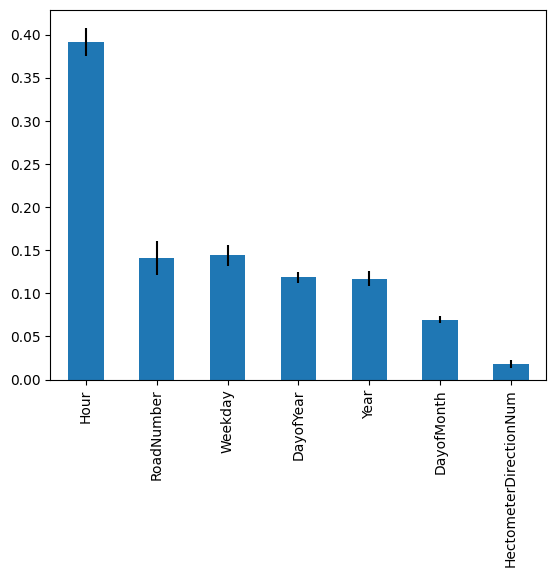

In [71]:
forest_importances = pd.Series(random_forest.feature_importances_, index=features)
standard_deviation = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
plt.figure()
forest_importances.plot.bar(yerr=standard_deviation)
plt.show()

#### Cross-validation

In [79]:
warnings.filterwarnings('ignore')
patch_sklearn()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = cross_val_score(random_forest, X_train, y_train, cv=skf, scoring='accuracy')# average accuracy score
print("Accuracy scores for each fold:", accuracy_scores)
average_accuracy = accuracy_scores.mean()
print("Average accuracy score:", average_accuracy)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Accuracy scores for each fold: [0.84975924 0.84922422 0.84913713 0.84945875 0.85035461]
Average accuracy score: 0.8495867907911142


### Inference

In [80]:
warnings.filterwarnings('ignore')
today = date.today()

hour = 7
road = 2
direction = 0
weekday = today.weekday()
dayofyear = today.timetuple().tm_yday
year = today.year
dayofmonth = today.day

X_inference = pd.DataFrame([{"Hour": hour, 
                             "RoadNumber": road,
                             "Weekday": weekday,
                             "DayofYear": dayofyear,
                             "Year": year,
                             "DayofMonth": dayofmonth,
                             "HectometerDirectionNum": direction}])

prediction = random_forest.predict_proba(X_inference)

result = pd.DataFrame()
result["Probability"] = prediction[0]

result

,Probability
0,0.095000
1,0.713417
2,0.141189
3,0.050394
